In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
# load data
data_path = "../data/answers-dataset-0.2.0.csv"
df = pd.read_csv(data_path)

In [ ]:
# some of the data has already been preprocessed calculating a final score 
# for some variables, e.g. CESD test

In [41]:
colnames = df.columns.tolist()

In [42]:
print(colnames)

['id', 'age', 'sex', 'transgender', 'left_handed', 'college_educated', 'wd_ttb', 'wd_tts', 'wd_bts', 'wd_sol', 'wd_nwak', 'wd_waso', 'wd_tfa', 'wd_tob', 'wd_ema', 'wd_sq', 'wd_tib', 'wd_twt', 'wd_tst', 'wd_se', 'we_ttb', 'we_tts', 'we_bts', 'we_sol', 'we_nwak', 'we_waso', 'we_tfa', 'we_tob', 'we_ema', 'we_sq', 'we_tib', 'we_twt', 'we_tst', 'we_se', 'msw', 'msf', 'msfsc1', 'msfsc2', 'socialjetlag', 'psqi_1', 'psqi_2', 'psqi_3', 'psqi_4', 'psqi_5a', 'psqi_5b', 'psqi_5c', 'psqi_5d', 'psqi_5e', 'psqi_5f', 'psqi_5g', 'psqi_5h', 'psqi_5i', 'psqi_5j', 'psqi_6', 'psqi_7', 'psqi_8', 'psqi_9', 'psqi_10', 'psqi_11a', 'psqi_11b', 'psqi_11c', 'psqi_11d', 'psqi_11e', 'psqi_c1', 'psqi_c2', 'psqi_c3', 'psqi_c4', 'psqi_c5', 'psqi_c6', 'psqi_c7', 'psqi_total', 'brisc_1', 'brisc_2', 'brisc_3', 'brisc_4', 'brisc_total', 'isi_1', 'isi_2', 'isi_3', 'isi_4', 'isi_5', 'isi_6', 'isi_7', 'isi_total', 'upps_1', 'upps_2', 'upps_3', 'upps_4', 'upps_5', 'upps_6', 'upps_7', 'upps_8', 'upps_9', 'upps_10', 'upps_11', 

In [50]:
# sex
df['sex'] = df['sex'].replace({'Male': 0, 'Female': 1})
# hispanic ethnicity
df['hispanic'] = df['ethnicity'].replace({'Non-Hispanic': 0, 'Hispanic': 1})
df.drop(columns=['ethnicity'], inplace=True)
# lefthanded
df['handedness'] = df['handedness'].replace({'Right': 0, 'Left': 1, 'Both': 1})
df.rename(columns={'handedness': 'left_handed'}, inplace=True)
# education
df = df.dropna(subset=['education'])
df['education'] = df['education'].replace({'High school or less': 0, 'College or more': 1})
df.rename(columns={'education': 'college_educated'}, inplace=True)

/tmp/ipykernel_2475/2778351387.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sex'] = df['sex'].replace({'Male': 0, 'Female': 1})
/tmp/ipykernel_2475/2778351387.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['hispanic'] = df['ethnicity'].replace({'Non-Hispanic': 0, 'Hispanic': 1})
/tmp/ipykernel_2475/2778351387.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the

In [51]:
def create_dummy_variables(data, column):
    dummy_variables = pd.get_dummies(data[column])
    dummy_variables = dummy_variables.astype(int)
    data = pd.concat([data, dummy_variables], axis=1)
    data.drop(columns=[column], inplace=True)
    return data

In [52]:
# race
df = create_dummy_variables(df, 'race')
# orientation
df = create_dummy_variables(df, 'orientation')
df.rename(columns={'Other': 'other_orientation'}, inplace=True)
# income
df = create_dummy_variables(df, 'income')
df.rename(columns={'Prefer not to say': 'income_notsay'}, inplace=True)

In [53]:
df = df.replace({'No': 0, 'Yes': 1})

/tmp/ipykernel_2475/2664658427.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({'No': 0, 'Yes': 1})


In [54]:
df['subs_caff_1'] = df['subs_caff_1'].apply(lambda x: "Caffeine " + x)
df['subs_tob_1'] = df['subs_tob_1'].apply(lambda x: "Tobacco " + x)
df['subs_alc_1'] = df['subs_alc_1'].apply(lambda x: "Alcohol " + x)
df['subs_can_1'] = df['subs_can_1'].apply(lambda x: "Cannabis " + x)

In [55]:
df = create_dummy_variables(df, 'subs_caff_1')
df = create_dummy_variables(df, 'subs_tob_1')
df = create_dummy_variables(df, 'subs_alc_1')
df = create_dummy_variables(df, 'subs_can_1')

In [56]:
df['psqi_1'] = df['psqi_1'].str.replace(r'\.000$', '', regex=True)
df['psqi_1'] = pd.to_datetime(df['psqi_1'], format='%H:%M:%S')
df['sleep_hour'] = df['psqi_1'].dt.hour
df['sleep_minute'] = df['psqi_1'].dt.minute
df['sleep_decimal_time'] = df['sleep_hour'] + df['sleep_minute'] / 60
df.drop(columns=['sleep_hour', 'sleep_minute'], inplace=True)
#hour_dummies = pd.get_dummies(df['hour'], prefix='sleep_hour_')
#df = pd.concat([df, hour_dummies], axis=1)
#df.drop(columns=['hour'], inplace=True)

In [57]:
df['psqi_3'] = df['psqi_3'].str.replace(r'\.000$', '', regex=True)
df['psqi_3'] = pd.to_datetime(df['psqi_3'], format='%H:%M:%S')
df['wake_hour'] = df['psqi_3'].dt.hour
df['wake_minute'] = df['psqi_3'].dt.minute
df['wake_decimal_time'] = df['wake_hour'] + df['wake_minute'] / 60
df.drop(columns=['wake_hour', 'wake_minute'], inplace=True)
#hour_dummies = pd.get_dummies(df['hour'], prefix='wake_hour_')
#df = pd.concat([df, hour_dummies], axis=1)
#df.drop(columns=['hour'], inplace=True)

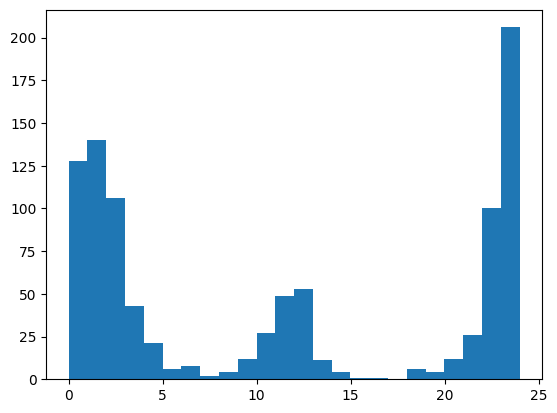

In [60]:
plt.hist(df['sleep_decimal_time'], bins = 24)
plt.show()

In [20]:
# identify predictor variables
pred_vars = [
    # general demographic
    'age', 'sex', 'Asian', 'Black', 'Islander', 'Multiracial', 'Native', 
    'White', 'hispanic', 'Bisexual', 'Heterosexual', 'Homosexual', 'other_orientation', 
    'transgender', 'left_handed', 'college_educated', '$100,000 - $200,000', 
    '$25,000 - $50,000', '$50,000 - $100,000', '< $25,000', '>$200,000', 'income_notsay', 
    # weekday sleep info
    'wd_ttb', 'wd_tts', 'wd_bts', 'wd_sol', 'wd_nwak', 'wd_waso', 'wd_tfa', 
    'wd_tob', 'wd_ema', 'wd_sq', 'wd_tib', 'wd_twt', 'wd_tst', 'wd_se', 
    # weekend sleep info
    'we_ttb', 'we_tts', 'we_bts', 'we_sol', 'we_nwak', 'we_waso', 'we_tfa', 
    'we_tob', 'we_ema', 'we_sq', 'we_tib', 'we_twt', 'we_tst', 'we_se',
    # weekday-weekend comparison info
    'msw', 'msf', 'msfsc1', 'msfsc2', 'socialjetlag',
    # pittsburgh sleep quality index
    'sleep_decimal_time', 'psqi_2', 'wake_decimal_time', 'psqi_4', 'psqi_5a', 'psqi_5b', 'psqi_5c', 
    'psqi_5d', 'psqi_5e', 'psqi_5f', 'psqi_5g', 'psqi_5h', 'psqi_5i', 'psqi_5j', 
    'psqi_6', 'psqi_7', 'psqi_8', 'psqi_9', 'psqi_10', 'psqi_11a', 'psqi_11b', 
    'psqi_11c', 'psqi_11d', 'psqi_11e', 'psqi_c1', 'psqi_c2', 'psqi_c3', 'psqi_c4', 
    'psqi_c5', 'psqi_c6', 'psqi_c7', 'psqi_total',
    # brief index of sleep control 
    'brisc_1', 'brisc_2', 'brisc_3', 'brisc_4', 'brisc_total',
    # insomnia severity index
    'isi_1', 'isi_2', 'isi_3', 'isi_4', 'isi_5', 'isi_6', 'isi_7', 'isi_total',
    # sleep disorders symptoms
    'sds_1', 'sds_2', 'sds_3', 'sds_4', 'sds_5', 'sds_6', 'sds_7', 'sds_8', 
    'sds_9', 'sds_10', 'sds_11', 'sds_12', 'sds_13', 'sds_14', 'sds_15', 
    'sds_16', 'sds_17', 'sds_18', 'sds_19', 'sds_20', 'sds_21', 'sds_22', 'sds_23', 
    'sds_24', 'sds_25',
    # disturbing dream and nightmare
    'ddnsi_1', 'ddnsi_2', 'ddnsi_3', 'ddnsi_4', 'ddnsi_5', 'ddnsi_total',
    # caffeine
    'Caffeine A few times a week', 'Caffeine Daily', 'Caffeine Multiple times daily', 
    'Caffeine Never', 'Caffeine Once a month or less', 'Caffeine Once a week or less', 
    'subs_caff_05to08', 'subs_caff_08to11', 'subs_caff_11to14', 'subs_caff_14to17', 
    'subs_caff_17to20', 'subs_caff_20to23', 'subs_caff_23to02', 'subs_caff_02to05',
    # tobacco
    'Tobacco Daily Smoker', 'Tobacco Former Smoker', 'Tobacco Never Smoker', 
    'Tobacco Occasional Smoker', 'subs_tob_05to08', 'subs_tob_08to11', 'subs_tob_11to14', 
    'subs_tob_14to17', 'subs_tob_17to20', 'subs_tob_20to23', 'subs_tob_23to02', 
    'subs_tob_02to05', 
    # alcohol
    'Alcohol A few times a week', 'Alcohol Daily', 'Alcohol Multiple times daily', 
    'Alcohol Never', 'Alcohol Once a month or less', 'Alcohol Once a week or less', 
    'subs_alc_05to08', 'subs_alc_08to11', 'subs_alc_11to14', 'subs_alc_14to17', 
    'subs_alc_17to20', 'subs_alc_20to23', 'subs_alc_23to02', 'subs_alc_02to05', 
    # cannabis
    'Cannabis A few times a week', 'Cannabis Daily', 'Cannabis Multiple times daily', 
    'Cannabis Never', 'Cannabis Once a month or less', 'Cannabis Once a week or less', 
    'subs_can_05to08', 'subs_can_08to11', 'subs_can_11to14', 'subs_can_14to17', 
    'subs_can_17to20', 'subs_can_20to23', 'subs_can_23to02', 'subs_can_02to05'
    ]

In [21]:
predictors = df[pred_vars]

In [23]:
predictors.to_csv('output.csv', index=False)

In [57]:
predictors.head()

,age,sex,Asian,Black,Islander,Multiracial,Native,White,hispanic,Bisexual,...,subs_can_1,subs_can_05to08,subs_can_08to11,subs_can_11to14,subs_can_14to17,subs_can_17to20,subs_can_20to23,subs_can_23to02,subs_can_02to05,subs_can_3
0,18.75,1,0,0,0,0,0,1,0,0,...,Never,No,No,No,No,No,No,No,No,Never
1,19.74,1,0,0,0,1,0,0,0,1,...,Never,No,No,No,No,No,No,No,No,Never
2,27.33,1,0,0,0,0,0,1,0,1,...,Multiple times daily,No,Yes,No,Yes,No,Yes,No,No,Often
3,29.60,1,0,0,0,0,0,1,0,0,...,Never,No,No,No,No,No,No,No,No,Never
4,26.71,1,0,0,0,0,0,1,1,0,...,Never,No,No,No,No,No,No,No,No,Never


In [25]:
non_numeric_columns = predictors.select_dtypes(exclude=[int, float]).columns

In [26]:
non_numeric_columns

Index(['psqi_1', 'psqi_3'], dtype='object')

In [22]:
sns.clustermap(predictors.corr(), cmap='viridis')
plt.show()

ValueError: could not convert string to float: '4:00:00.000'

In [ ]:
# subset_df = df[predictor_variables + ["outcome_1"]]

In [ ]:
# standardize variables

In [ ]:
# autocorrelation?